In [1]:
from pykeen.pipeline import pipeline

from pykeen.models import TransE
from pykeen.models import RESCAL
from pykeen.models import predict

from pykeen.datasets import YAGO310
from pykeen.datasets import FB15k237
from pykeen.datasets import WN18

from pykeen.models.predict import get_relation_prediction_df
from pykeen.models.predict import get_all_prediction_df
from pykeen.models.predict import predict_triples_df

from pykeen.datasets.analysis import get_relation_count_df
from pykeen.datasets.analysis import get_entity_count_df
#from pykeen.datasets.analysis import get_relation_functionality_df
#from pykeen.datasets.analysis import get_entity_relation_co_occurrence_df
from pykeen.datasets.analysis import get_relation_pattern_types_df

from pykeen.triples.triples_factory import tensor_to_df
from pykeen.triples.triples_factory import CoreTriplesFactory
from pykeen.triples.triples_factory import TriplesFactory


import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from collections import Counter

import scipy.stats as stats

from tqdm import tqdm

E:\AnacondaPython\envs\Thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = FB15k237()

mapped_triples_training = dataset.training.mapped_triples
mapped_triples_testing = dataset.testing.mapped_triples

entity_to_id=dataset.training.entity_to_id
relation_to_id=dataset.training.relation_to_id

training_S = TriplesFactory(mapped_triples_training, entity_to_id, relation_to_id)
testing_S = TriplesFactory(mapped_triples_testing, entity_to_id, relation_to_id)

You're trying to map triples with 30 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 28 from 20466 triples were filtered out


In [3]:
pipeline_result_s = pipeline(
    training=training_S,
    testing=testing_S,
    model= RESCAL,
    model_kwargs = dict(predict_with_sigmoid=True),
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    #number of epochs should be increased. Now it is computationally too expensive
    training_kwargs=dict(
        num_epochs=128,
        checkpoint_name='checkpoint_s.pt',
        checkpoint_frequency=5,),
    random_seed = 3757357109,
    #result_tracker='mlflow',
    #result_tracker_kwargs=dict(
        #tracking_uri='http://localhost:5000',
        #experiment_name='Training of TransE on Nations',
    #),
    
)
#pipeline_result.save_to_directory(r'C:\Users\tommy\OneDrive\Documenten\year 3\Bachelor AI Project\coding')

#seed 3757357109

No cuda devices were available. The model runs on CPU
E:\AnacondaPython\envs\Thesis\lib\site-packages\pykeen\nn\representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
INFO:pykeen.training.training_loop:=> loading checkpoint 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
INFO:pykeen.training.training_loop:=> loaded checkpoint 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt' stopped after having finished epoch 129
INFO:pykeen.stoppers.stopper:=> loading stopper summary dict from training loop checkpoint in 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
INFO:pykeen.stoppers.stopper:=> loaded stopper summary dictionary from checkpoint in 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
Training epochs on cpu: 129epoch [00:00, ?epoch/s]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimiz

In [4]:
mapped_triples = dataset.training.mapped_triples
model = pipeline_result_s.model
triples_factory = pipeline_result_s.training

entity_labels = pipeline_result_s.training.entity_id_to_label
entity_labels_df = pd.DataFrame.from_dict(entity_labels, orient='index', columns=['entity_label'])

relation_labels = pipeline_result_s.training.relation_id_to_label
relation_labels_df = pd.DataFrame.from_dict(relation_labels, orient='index', columns=['relation_label'])

entity_labels_df.head()
relation_labels_df.head()

,relation_label
0,/american_football/football_team/current_roste...
1,/award/award_category/category_of
2,/award/award_category/disciplines_or_subjects
3,/award/award_category/nominees./award/award_no...
4,/award/award_category/winners./award/award_hon...


In [5]:
#clustering of entities:
    
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import seaborn as sns

triple_array = np.array(mapped_triples)

kmeans = KMeans(n_clusters=3, random_state=0)

cluster_labels = kmeans.fit_predict(triple_array)


cluster_df = pd.DataFrame(triple_array, columns=['head', 'relation','tail'])
cluster_df['cluster_label'] = cluster_labels
print (cluster_df)

         head  relation   tail  cluster_label
0           0       120  13647              1
1           0       125  13647              1
2           0       126      0              0
3           0       127  12940              1
4           0       129   8652              1
...       ...       ...    ...            ...
272110  14503        50  10165              2
272111  14503       125  13680              2
272112  14503       126  14503              2
272113  14503       127  12940              2
272114  14504       127  12940              2

[272115 rows x 4 columns]


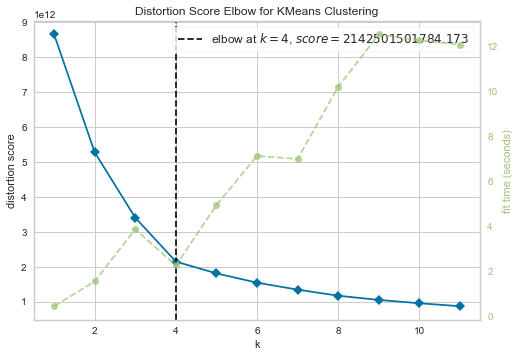

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# elbow method for determining k

from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(1,12)).fit(cluster_df)
visualizer.show()

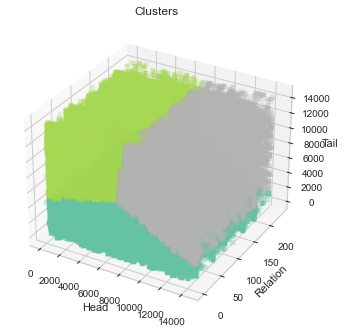

these are the coordinates for the centroids: 
 [[ 6197.28648103    96.83152538  3108.27848688]
 [ 3592.50546214    98.5987731  10046.84958314]
 [11051.1425831     95.14467673  9335.17109972]]
 
these are the closest datapoints to each centroid / representatives for eacht cluster: 
 
[[6198   59 3086]] [43.90973012]
[[ 3632    93 10033]] [42.22529733]
[[11082   113  9322]] [38.0061918]


In [7]:
#determining centroids and visualizing clusters:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min



kmeans = KMeans(n_clusters=3, random_state=0)

cluster_labels = kmeans.fit_predict(triple_array)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(cluster_df['head'])
y = np.array(cluster_df['relation'])
z = np.array(cluster_df['tail'])

ax.scatter(x,y,z, marker="s", c=cluster_df["cluster_label"], s=20, alpha=0.25, cmap="Set2")
ax.set_title('Clusters')
ax.set_xlabel('Head')
ax.set_ylabel('Relation')
ax.set_zlabel('Tail')

centroids = kmeans.cluster_centers_

ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           kmeans.cluster_centers_[:,2], s = 900, c = 'r',
           marker='o', label = 'Centroid', alpha=1)


plt.show()

closest, _ = pairwise_distances_argmin_min(centroids, triple_array)

print("these are the coordinates for the centroids: \n", centroids)
print(" ")
print("these are the closest datapoints to each centroid / representatives for eacht cluster: ")
print(" ")


representatives_list = []
#get the closest datapoints to each centroid
for i in centroids:
    closest, distance = pairwise_distances_argmin_min([i], triple_array)
    representatives = (triple_array[closest], distance)
    representatives_list.append(representatives[0])
    print(representatives[0], representatives[1])
    


In [8]:
representatives_list_with_labels = []

for triple in representatives_list:
    representatives_list_with_labels.append(
        [
        entity_labels_df.iloc[triple[0][0]][0], 
         entity_labels_df.iloc[triple[0][2]][0],
            triple[0][0],
                triple[0][2]
        ],
        
    )

print(representatives_list_with_labels)

[['/m/03hvk2', '/m/01z0lb', 6198, 3086], ['/m/026hh0m', '/m/086k8', 3632, 10033], ['/m/0bymv', '/m/070m6c', 11082, 9322]]


In [9]:
dataframes = []
entity_tails = []

for i in representatives_list_with_labels:
    pred_df = get_relation_prediction_df(model, i[0], i[1], add_novelties=True ,triples_factory=pipeline_result_s.training)
    pred_df['head_label'] = i[0]
    pred_df['tail_label'] = i[1]
    pred_df['head_id'] = i[2]
    pred_df['tail_id'] = i[3]
    dataframes.append(pred_df)
    entity_tails.append([i[0], i[1]])
    
result_s = pd.concat(dataframes)


In [10]:
result_s = result_s.reset_index(drop=True)
result_s

,relation_id,relation_label,score,in_training,head_label,tail_label,head_id,tail_id
0,0,/american_football/football_team/current_roste...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
1,163,/olympics/olympic_participating_country/athlet...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
2,151,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
3,152,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
4,153,/music/instrument/family,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
...,...,...,...,...,...,...,...,...
706,25,/base/eating/practicer_of_diet/diet,0.5,False,/m/0bymv,/m/070m6c,11082,9322
707,60,/education/educational_institution_campus/educ...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
708,202,/sports/professional_sports_team/draft_picks./...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
709,76,/film/film/dubbing_performances./film/dubbing_...,0.5,False,/m/0bymv,/m/070m6c,11082,9322


In [11]:
triples_not_in_training_s = result_s[result_s['in_training'] == False]
triples_not_in_training_s

,relation_id,relation_label,score,in_training,head_label,tail_label,head_id,tail_id
0,0,/american_football/football_team/current_roste...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
1,163,/olympics/olympic_participating_country/athlet...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
2,151,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
3,152,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
4,153,/music/instrument/family,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
...,...,...,...,...,...,...,...,...
706,25,/base/eating/practicer_of_diet/diet,0.5,False,/m/0bymv,/m/070m6c,11082,9322
707,60,/education/educational_institution_campus/educ...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
708,202,/sports/professional_sports_team/draft_picks./...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
709,76,/film/film/dubbing_performances./film/dubbing_...,0.5,False,/m/0bymv,/m/070m6c,11082,9322


In [12]:
head_id = triples_not_in_training_s['head_id'].to_list()
relation_id = triples_not_in_training_s['relation_id'].to_list()
tail_id = triples_not_in_training_s['tail_id'].to_list()

triples_not_in_training_ids = []

for idx, ele in enumerate(head_id):
    triples_not_in_training_ids.append([ele, relation_id[idx], tail_id[idx]])
    
    
triples_not_in_training_ids_array = np.array(triples_not_in_training_ids)

print('length of triples to inspect: ', len(triples_not_in_training_ids_array))
print(' ')
print('triples array to inspect:\n', triples_not_in_training_ids_array)

length of triples to inspect:  708
 
triples array to inspect:
 [[ 6198     0  3086]
 [ 6198   163  3086]
 [ 6198   151  3086]
 ...
 [11082   202  9322]
 [11082    76  9322]
 [11082   204  9322]]


In [13]:
from pykeen.triples import TriplesFactory
from pykeen.triples import CoreTriplesFactory
from pykeen.datasets.nations import NATIONS_TRAIN_PATH, NATIONS_TEST_PATH
import torch

mapped_triples_training = pipeline_result_s.training.mapped_triples
mapped_triples_testing = dataset.testing.mapped_triples

mapped_triples_training_array = mapped_triples_training.numpy()

add_triple = triples_not_in_training_ids_array[[0]]

length = len(mapped_triples_training)/10

for i in range(int(length)):
    mapped_triples_training_array = np.concatenate((mapped_triples_training_array, add_triple))

pt_tensor_from_list = torch.Tensor(mapped_triples_training_array)
mapped_triples_training_plus_representative_triple = pt_tensor_from_list.type(torch.int64)

print('mapped triples of training result from first pipeline: ')
print(mapped_triples_training)
print(' ')
print('add representatives to this set')
print(' ')
print('amount of oversampling: ', int(length))
print(' ')

#entity_labels = pipeline_result.training.entity_id_to_label
#print(entity_labels)
#relation_labels = pipeline_result.training.relation_id_to_label
#print(relation_labels)

print('mapped triples tensor with the representative triple: ')
print(mapped_triples_training_plus_representative_triple)


mapped triples of training result from first pipeline: 
tensor([[    0,   120, 13647],
        [    0,   125, 13647],
        [    0,   126,     0],
        ...,
        [14503,   126, 14503],
        [14503,   127, 12940],
        [14504,   127, 12940]])
 
add representatives to this set
 
amount of oversampling:  27211
 
mapped triples tensor with the representative triple: 
tensor([[    0,   120, 13647],
        [    0,   125, 13647],
        [    0,   126,     0],
        ...,
        [ 6198,     0,  3086],
        [ 6198,     0,  3086],
        [ 6198,     0,  3086]])


In [14]:
entity_to_id=pipeline_result_s.training.entity_to_id
relation_to_id=pipeline_result_s.training.relation_to_id

In [15]:
training_A = TriplesFactory(mapped_triples_training_plus_representative_triple, entity_to_id, relation_to_id)
testing_A = TriplesFactory(mapped_triples_testing, entity_to_id, relation_to_id)

In [16]:
pipeline_result_A = pipeline(
    training=training_A,
    testing=testing_A,
    model= RESCAL,
    model_kwargs = dict(predict_with_sigmoid=True),
    training_loop='sLCWA',
    negative_sampler='basic',
    evaluator='RankBasedEvaluator',
    #number of epochs should be increased. Now it is computationally too expensive
    training_kwargs=dict(
        num_epochs=129,
        checkpoint_name='checkpoint_s.pt',
        checkpoint_frequency=5,),
    random_seed = 3757357109,
    #result_tracker='mlflow',
    #result_tracker_kwargs=dict(
        #tracking_uri='http://localhost:5000',
        #experiment_name='Training of TransE on Nations',
    #),
    
)
#pipeline_result.save_to_directory(r'C:\Users\tommy\OneDrive\Documenten\year 3\Bachelor AI Project\coding')

#seed 3757357109

INFO:pykeen.pipeline.api:loaded random seed 3757357109 from checkpoint.
INFO:pykeen.pipeline.api:Using device: None
E:\AnacondaPython\envs\Thesis\lib\site-packages\pykeen\nn\representation.py:372: UserWarning: Directly use Embedding.max_id instead of num_embeddings.
  warnings.warn(f"Directly use {self.__class__.__name__}.max_id instead of num_embeddings.")
INFO:pykeen.training.training_loop:=> loading checkpoint 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
INFO:pykeen.training.training_loop:=> loaded checkpoint 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt' stopped after having finished epoch 129
INFO:pykeen.stoppers.stopper:=> loading stopper summary dict from training loop checkpoint in 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
INFO:pykeen.stoppers.stopper:=> loaded stopper summary dictionary from checkpoint in 'C:\Users\Tommy Lohn\.data\pykeen\checkpoints\checkpoint_s.pt'
Training epochs on cpu: 100%|██████████| 129/129 [00:00<

In [17]:
dataframes = []
entity_tails = []

model_A = pipeline_result_A.model
for i in representatives_list_with_labels:
    pred_df = get_relation_prediction_df(model_A, i[0], i[1], add_novelties=True ,triples_factory=pipeline_result_A.training)
    pred_df['head_label'] = i[0]
    pred_df['tail_label'] = i[1]
    pred_df['head_id'] = i[2]
    pred_df['tail_id'] = i[3]
    dataframes.append(pred_df)
    entity_tails.append([i[0], i[1]])
    
result_A = pd.concat(dataframes)


In [18]:
result_A = result_A.reset_index(drop=True)
result_A

,relation_id,relation_label,score,in_training,head_label,tail_label,head_id,tail_id
0,0,/american_football/football_team/current_roste...,0.5,True,/m/03hvk2,/m/01z0lb,6198,3086
1,163,/olympics/olympic_participating_country/athlet...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
2,151,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
3,152,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
4,153,/music/instrument/family,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
...,...,...,...,...,...,...,...,...
706,25,/base/eating/practicer_of_diet/diet,0.5,False,/m/0bymv,/m/070m6c,11082,9322
707,60,/education/educational_institution_campus/educ...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
708,202,/sports/professional_sports_team/draft_picks./...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
709,76,/film/film/dubbing_performances./film/dubbing_...,0.5,False,/m/0bymv,/m/070m6c,11082,9322


In [19]:
triples_not_in_training_A = result_A[result_A['in_training'] == False]
triples_not_in_training_A

,relation_id,relation_label,score,in_training,head_label,tail_label,head_id,tail_id
1,163,/olympics/olympic_participating_country/athlet...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
2,151,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
3,152,/music/group_member/membership./music/group_me...,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
4,153,/music/instrument/family,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
5,154,/music/instrument/instrumentalists,0.5,False,/m/03hvk2,/m/01z0lb,6198,3086
...,...,...,...,...,...,...,...,...
706,25,/base/eating/practicer_of_diet/diet,0.5,False,/m/0bymv,/m/070m6c,11082,9322
707,60,/education/educational_institution_campus/educ...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
708,202,/sports/professional_sports_team/draft_picks./...,0.5,False,/m/0bymv,/m/070m6c,11082,9322
709,76,/film/film/dubbing_performances./film/dubbing_...,0.5,False,/m/0bymv,/m/070m6c,11082,9322


In [20]:
triples_not_in_training_s_copy = triples_not_in_training_s.copy()
triples_not_in_training_s_copy.drop(index=triples_not_in_training_s_copy.index[0], 
        axis=0, 
        inplace=True)

In [21]:
tauA, p_valueA = stats.kendalltau(triples_not_in_training_s_copy['score'], triples_not_in_training_A['score'])
print(tauA, p_valueA)

0.9999999999999999 1.7860723795976102e-162
